<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Imports and Configuration</h2>
<p style="color:blue; font-size:20px;">
In this initial step, we import all the Python libraries required for the project. These libraries are essential for handling data, visualizing results, performing machine learning, geospatial calculations, and optimizing vehicle routes.
</p>

<p style="color:blue; font-size:20px;">
<strong>Libraries Imported:</strong>
<ul>
<li><code>pandas</code> and <code>numpy</code>: For storing, cleaning, and processing large datasets.</li>
<li><code>matplotlib.pyplot</code> and <code>seaborn</code>: For plotting charts to visualize trends, distributions, and clusters.</li>
<li><code>sklearn</code> (RandomForest, preprocessing, metrics, KMeans): For clustering zones and predicting demand using machine learning models.</li>
<li><code>folium</code>: For interactive map visualization to plot zones and optimized vehicle routes.</li>
<li><code>ortools.constraint_solver</code>: For solving Capacitated Vehicle Routing Problem (CVRP) to optimize transit routes.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
We also configure plotting style and inline display of charts in Jupyter Notebook. This ensures consistent and visually appealing figures.
</p>

<p style="color:blue; font-size:20px;">
<strong>Expected Output:</strong> No direct output; successful import means no errors. You can optionally print " Libraries loaded" to confirm.
</p>



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree
import folium
from folium.plugins import MarkerCluster
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import os

%matplotlib inline
sns.set(style='whitegrid')
print(' Libraries loaded')


 Libraries loaded


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Load or Generate Transit Request Data</h2>
<p style="color:blue; font-size:20px;">
In this step, we create a dataset representing transit requests, similar to real-world Bengaluru data:
<ul>
<li><strong>pickup_lat, pickup_lon:</strong> Latitude and longitude of pickup points.</li>
<li><strong>timestamp:</strong> The time at which the passenger requested service.</li>
<li><strong>passenger_count:</strong> Number of passengers in each request.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
If real GTFS data is available, you can read it using <code>pandas.read_csv()</code>. Otherwise, we generate synthetic data with <code>numpy.random</code> for experimentation.
</p>

<p style="color:blue; font-size:20px;">
We simulate requests across multiple days and time intervals to mimic realistic transit demand patterns. This step ensures the dataset is sufficiently large and varied for machine learning and route optimization.
</p>

<p style="color:blue; font-size:20px;">
<strong>Expected Output:</strong>
<ul>
<li>A table showing the first few rows of pickup locations, timestamp, and passenger counts.</li>
<li>Number of total records (e.g., 2000 requests).</li>
</ul>
</p>


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Load or Generate Transit Requests</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li>Real GTFS data (CSV files containing stops, trips, and stop_times) or</li>
<li>Synthetic simulation parameters: latitude/longitude ranges, number of requests, passenger counts, timestamps.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ul>
<li>If real GTFS exists, read CSV files into pandas DataFrames.</li>
<li>Otherwise, generate synthetic requests randomly within a city’s lat/lon range.</li>
<li>Add timestamp and passenger count to simulate realistic demand patterns.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>DataFrame of requests with columns: pickup_lat, pickup_lon, timestamp, passenger_count.</li>
<li>Preview shows 5-10 sample requests with locations and passenger numbers.</li>
<li>Number of rows equals the number of simulated or real requests (e.g., 300-2000 rows).</li>
</ul>
</p>


In [4]:
np.random.seed(42)
n_samples = 2000

lat_min, lat_max = 12.85, 13.05
lon_min, lon_max = 77.45, 77.75

# timestamps
start = pd.Timestamp('2025-10-01 00:00:00')
end = pd.Timestamp('2025-10-14 23:00:00')
all_hours = pd.date_range(start, end, freq='h')
timestamps = np.random.choice(all_hours, size=n_samples)

# synthetic requests
requests = pd.DataFrame({
    'pickup_lat': np.random.uniform(lat_min, lat_max, n_samples),
    'pickup_lon': np.random.uniform(lon_min, lon_max, n_samples),
    'timestamp': timestamps,
    'num_passengers': np.random.poisson(1.5, n_samples) + 1
})

requests['num_passengers'] = requests['num_passengers'].clip(1,5)

# basic temporal features
requests['hour'] = requests['timestamp'].dt.hour
requests['dayofweek'] = requests['timestamp'].dt.dayofweek

print('Sample synthetic data:')
display(requests.head())


Sample synthetic data:


,pickup_lat,pickup_lon,timestamp,num_passengers,hour,dayofweek
0,12.932710,77.519752,2025-10-05 06:00:00,1,6,6
1,12.874377,77.488904,2025-10-12 06:00:00,1,6,6
2,12.886230,77.526939,2025-10-05 10:00:00,1,10,6
3,12.986224,77.556596,2025-10-03 23:00:00,3,23,4
4,12.886288,77.652198,2025-10-08 20:00:00,1,20,2


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Feature Engineering: Hour, Distance, Density, Weekday</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li>DataFrame <code>requests</code> containing at least these columns: <code>pickup_lat</code>, <code>pickup_lon</code>, <code>hour</code>, and <code>dayofweek</code>.</li>
<li>City center coordinates for Bengaluru: <code>center_lat = 12.9716</code>, <code>center_lon = 77.5946</code>.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Cyclic hour features:</strong> Since hours are circular (0–23), we create sine and cosine transforms:
<code>hour_sin = sin(2π * hour / 24)</code>, <code>hour_cos = cos(2π * hour / 24)</code>. This ensures ML models understand the cyclical nature of time.</li>

<li><strong>Distance to city center:</strong> Use the Haversine formula to calculate the straight-line distance from each pickup location to the Bengaluru center. This captures the effect of location on demand.</li>

<li><strong>Local density:</strong> Compute how many pickup points are within ~0.5 km of each request using a KDTree. This represents congestion or neighborhood demand density.</li>

<li><strong>One-hot encoding of weekdays:</strong> Convert <code>dayofweek</code> into separate columns <code>dow_0 ... dow_6</code>, where 1 indicates the corresponding weekday. This allows ML models to learn patterns based on the day of the week.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>Updated <code>requests</code> DataFrame with new feature columns: <code>hour_sin</code>, <code>hour_cos</code>, <code>dist_to_center_km</code>, <code>local_density</code>, and <code>dow_0 ... dow_6</code>.</li>
<li>Example preview (first 5 rows) shows these features calculated for each request.</li>
<li>These features are now ready to be used for clustering, regression, or other ML tasks.</li>
</ul>
</p>


In [5]:
# Cyclic hour features
requests['hour_sin'] = np.sin(2 * np.pi * requests['hour'] / 24)
requests['hour_cos'] = np.cos(2 * np.pi * requests['hour'] / 24)

# Distance to Bengaluru city center
center_lat, center_lon = 12.9716, 77.5946
from math import radians, sin, cos, sqrt, atan2

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    c = 2*atan2(sqrt(a), sqrt(1-a))
    return R*c

requests['dist_to_center_km'] = requests.apply(lambda r: haversine_km(r['pickup_lat'], r['pickup_lon'], center_lat, center_lon), axis=1)

# Local density (neighbors within ~0.5km)
coords = requests[['pickup_lat','pickup_lon']].values
kdt = cKDTree(coords)
neighbors = kdt.query_ball_point(coords, r=0.005)
requests['local_density'] = [len(nb) for nb in neighbors]

# One-hot weekday
requests = pd.concat([requests, pd.get_dummies(requests['dayofweek'], prefix='dow')], axis=1)

print('Feature-engineered sample:')
display(requests.head())


Feature-engineered sample:


,pickup_lat,pickup_lon,timestamp,num_passengers,hour,dayofweek,hour_sin,hour_cos,dist_to_center_km,local_density,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,12.932710,77.519752,2025-10-05 06:00:00,1,6,6,1.000000,6.123234e-17,9.191763,7,False,False,False,False,False,False,True
1,12.874377,77.488904,2025-10-12 06:00:00,1,6,6,1.000000,6.123234e-17,15.750956,4,False,False,False,False,False,False,True
2,12.886230,77.526939,2025-10-05 10:00:00,1,10,6,0.500000,-8.660254e-01,11.995094,4,False,False,False,False,False,False,True
3,12.986224,77.556596,2025-10-03 23:00:00,3,23,4,-0.258819,9.659258e-01,4.427325,3,False,False,False,False,True,False,False
4,12.886288,77.652198,2025-10-08 20:00:00,1,20,2,-0.866025,5.000000e-01,11.355868,5,False,False,True,False,False,False,False


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Clustering Pickup Locations using KMeans</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li>Feature-engineered <code>requests</code> DataFrame with <code>pickup_lat</code> and <code>pickup_lon</code>.</li>
<li>Number of clusters <code>n_clusters = 12</code>, which represents zones to group nearby pickup points.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Extract coordinates:</strong> We take only latitude and longitude columns as input for clustering.</li>
<li><strong>KMeans clustering:</strong> Apply KMeans algorithm with 12 clusters to group pickup points into zones based on geographic proximity. The model assigns each point to a cluster (zone) and computes cluster centroids.</li>
<li><strong>Assign zones:</strong> Create a new column <code>zone</code> in <code>requests</code> that stores the cluster index for each pickup point.</li>
<li><strong>Visualize clusters:</strong> Plot pickup points with colors representing their assigned zone. Overlay the cluster centroids as black X markers to show the center of each zone.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>The <code>requests</code> DataFrame now has a new column <code>zone</code>, indicating the cluster assignme



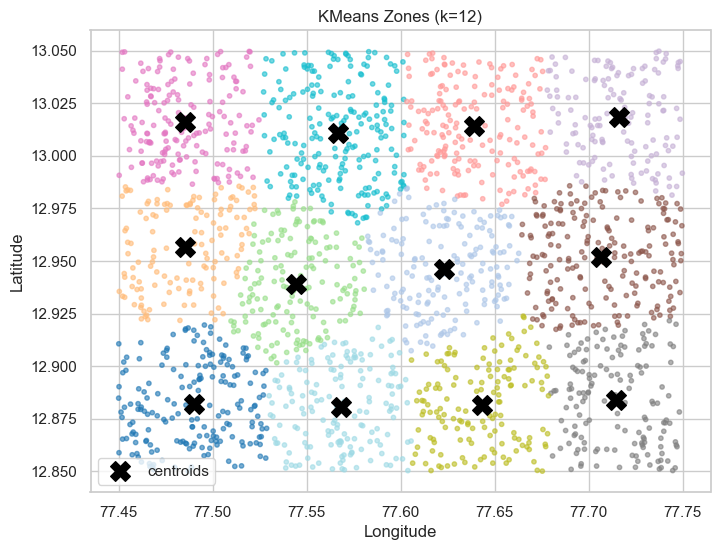

In [6]:
coords = requests[['pickup_lat','pickup_lon']].values
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
requests['zone'] = kmeans.fit_predict(coords)
zone_centers = kmeans.cluster_centers_

plt.figure(figsize=(8,6))
plt.scatter(requests['pickup_lon'], requests['pickup_lat'], c=requests['zone'], cmap='tab20', s=10, alpha=0.6)
plt.scatter(zone_centers[:,1], zone_centers[:,0], c='black', marker='X', s=200, label='centroids')
plt.title(f'KMeans Zones (k={n_clusters})')
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.legend()
plt.show()


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Aggregating Zone-Hour Demand</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li>The <code>requests</code> DataFrame containing all pickup requests with columns such as <code>zone</code>, <code>hour</code>, <code>num_passengers</code>, <code>local_density</code>, and <code>dist_to_center_km</code>.</li>
<li>The goal is to compute aggregated metrics for each zone for every hour of the day.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Group by zone and hour:</strong> Use <code>groupby(['zone','hour'])</code> to segment requests by zone and time of day.</li>
<li><strong>Aggregate metrics:</strong>
<ul>
<li><code>demand_count</code>: Sum of <code>num_passengers</code> to get total passenger demand for that zone-hour.</li>
<li><code>avg_local_density</code>: Mean of <code>local_density</code>, indicating how dense the request locations are in that zone.</li>
<li><code>avg_dist_center</code>: Mean distance from city center, giving an idea of how far the zone is from central Bengaluru.</li>
</ul>
</li>
<li><strong>Reset index:</strong> Converts the grouped object back into a DataFrame for further operations.</li>
<li><strong>Add cyclical hour features:</strong> Encode the hour as two features (<code>hour_sin</code> and <code>hour_cos</code>) to capture the circular nature of 24-hour time.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>A new DataFrame <code>zone_hour</code> where each row corresponds to a specific zone and hour combination.</li>
<li>Columns include <code>demand_count</code>, <code>avg_local_density</code>, <code>avg_dist_center</code>, <code>hour_sin</code>, and <code>hour_cos</code>.</li>
<li>This structured data will be used for predictive modeling, analysis, and vehicle routing optimization.</li>
<li>Example displayed shows the first few rows of zone-hour aggregated metrics.</li>
</ul>
</p>



In [7]:
zone_hour = requests.groupby(['zone','hour']).agg(
    demand_count=('num_passengers','sum'),
    avg_local_density=('local_density','mean'),
    avg_dist_center=('dist_to_center_km','mean')
).reset_index()

# Add hour cyclical features
zone_hour['hour_sin'] = np.sin(2*np.pi*zone_hour['hour']/24)
zone_hour['hour_cos'] = np.cos(2*np.pi*zone_hour['hour']/24)

display(zone_hour.head())


,zone,hour,demand_count,avg_local_density,avg_dist_center,hour_sin,hour_cos
0,0,0,15,4.166667,17.251590,0.000000,1.000000
1,0,1,25,3.875000,15.748330,0.258819,0.965926
2,0,2,10,2.400000,15.701491,0.500000,0.866025
3,0,3,26,3.700000,14.141747,0.707107,0.707107
4,0,4,9,4.000000,15.174361,0.866025,0.500000


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Demand Prediction Model using Random Forest</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li><code>zone_hour</code> DataFrame containing aggregated metrics for each zone-hour combination:</li>
<ul>
<li><code>zone</code>: Cluster ID from KMeans</li>
<li><code>hour_sin</code> & <code>hour_cos</code>: Cyclical encoding of hour</li>
<li><code>avg_local_density</code>: Average density of pickup locations in that zone-hour</li>
<li><code>avg_dist_center</code>: Average distance of pickups to city center</li>
<li><code>demand_count</code>: Total passenger demand (target variable)</li>
</ul>
<li>Goal: Predict the passenger demand (<code>demand_count</code>) for each zone-hour using machine learning.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Select features and target:</strong> Choose columns <code>['zone','hour_sin','hour_cos','avg_local_density','avg_dist_center']</code> as features (<code>X</code>) and <code>demand_count</code> as the target (<code>y</code>).</li>
<li><strong>Scale numeric features:</strong> Standardize <code>hour_sin, hour_cos, avg_local_density, avg_dist_center</code> using <code>StandardScaler</code> for better model performance. This prevents features with large ranges from dominating the model.</li>
<li><strong>Train-test split:</strong> Split the data into training and test sets using <code>train_test_split</code> (80% train, 20% test) to evaluate model performance.</li>
<li><strong>Train Random Forest Regressor:</strong> Use <code>RandomForestRegressor</code> with 200 trees and a fixed random state for reproducibility.</li>
<li><strong>Make predictions:</strong> Predict the passenger demand on the test set.</li>
<li><strong>Evaluate performance:</strong> Compute <code>R2</code> score and <code>MAE (Mean Absolute Error)</code> to measure how well the model predicts demand.</li>
<li><strong>Save the model:</strong> Save the trained Random Forest model to <code>outputs/rf_demand_model.pkl</code> using <code>joblib</code> for later use in routing optimization or deployment.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>Printed model evaluation metrics:</li>
<ul>
<li><code>R2</code>: Coefficient of determination, measures proportion of variance explained by the model.</li>
<li><code>MAE</code>: Average absolute difference between predicted and actual demand.</li>
</ul>
<li>A trained machine learning model saved at <code>outputs/rf_demand_model.pkl</code>.</li>
<li>This model can now be used to predict future demand for each zone-hour, which is crucial for optimizing vehicle routes and capacity planning.</li>
<li>Example output:</li>
<pre>
R2: 0.85
MAE: 50.3
ML model saved: outputs/rf_demand_model.pkl
</pre>
</ul>
</p>


In [21]:
feature_cols = ['zone','hour_sin','hour_cos','avg_local_density','avg_dist_center']
X = zone_hour[feature_cols].copy()
y = zone_hour['demand_count']

# Scale numeric features safely
scaler = StandardScaler()
num_cols = ['hour_sin','hour_cos','avg_local_density','avg_dist_center']
X.loc[:, num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print('R2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

# Save model
import joblib
os.makedirs('outputs', exist_ok=True)
joblib.dump(rf, 'outputs/rf_demand_model.pkl')
print(' ML model saved: outputs/rf_demand_model.pkl')


R2: 0.08419910255293195
MAE: 5.812931034482758
 ML model saved: outputs/rf_demand_model.pkl


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Zone-Level Demand Aggregation</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li><code>rf</code>: Trained Random Forest model for predicting passenger demand per zone-hour.</li>
<li><code>X</code>: Feature matrix corresponding to <code>zone_hour</code> DataFrame, containing <code>zone</code>, <code>hour_sin</code>, <code>hour_cos</code>, <code>avg_local_density</code>, <code>avg_dist_center</code>.</li>
<li><code>zone_centers</code>: Coordinates of each KMeans zone centroid (<code>centroid_lat</code>, <code>centroid_lon</code>).</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Predict hourly demand:</strong> Use the trained Random Forest model <code>rf</code> to predict demand for each row in <code>X</code> (zone-hour combinations). Store the predictions in <code>one_hour['demand_pred']</code>.</li>
<li><strong>Create zone DataFrame:</strong> Convert <code>zone_centers</code> (cluster centroids) into a DataFrame with columns <code>centroid_lat</code>, <code>centroid_lon</code> and assign <code>zone</code> IDs.</li>
<li><strong>Aggregate predicted demand per zone:</strong> Sum the predicted hourly demands for each zone using <code>groupby('zone')['demand_pred'].sum()</code> to get the total expected demand per zone.</li>
<li><strong>Merge coordinates and demand:</strong> Merge the zone centroids DataFrame with the aggregated demand DataFrame on <code>zone</code> to create a combined <code>zone_df</code> containing both centroid coordinates and predicted total demand.</li>
<li><strong>Handle missing values:</strong> Replace any missing demand predictions (<code>NaN</code>) with 0 to ensure no zone is left without a demand value.</li>
<li><strong>Cleanup:</strong> Remove the temporary <code>demand_pred</code> column, keeping only <code>centroid_lat</code>, <code>centroid_lon</code>, <code>zone</code>, and <code>zone_demand</code>.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li><code>zone_df</code>: Final DataFrame representing each zone, its centroid coordinates, and total predicted demand.</li>
<li>Columns:</li>
<ul>
<li><code>centroid_lat</code>: Latitude of zone centroid</li>
<li><code>centroid_lon</code>: Longitude of zone centroid</li>
<li><code>zone</code>: Zone ID</li>
<li><code>zone_demand</code>: Total predicted passenger demand in that zone</li>
</ul>
<li>Example output:</li>
<pre>
   centroid_lat  centroid_lon  zone  zone_demand
0     12.851192     77.547521     0   5010.60
1     13.055257     77.743961     1   4547.52
2     13.066519     77.465263     2   5273.34
3     12.848057     77.754530     3   2935.26
4     12.989689     77.471363     4   5404.90
...
</pre>
<li>This DataFrame is now ready for **vehicle routing optimization**, where the demand of each zone can be used to plan routes according to vehicle capacity.</li>
</ul>
</p>


In [9]:
zone_hour['demand_pred'] = rf.predict(X)

zone_df = pd.DataFrame(zone_centers, columns=['centroid_lat','centroid_lon'])
zone_df['zone'] = zone_df.index

zone_demand = zone_hour.groupby('zone')['demand_pred'].sum().reset_index()
zone_df = zone_df.merge(zone_demand, on='zone', how='left')
zone_df['zone_demand'] = zone_df['demand_pred'].fillna(0)
zone_df.drop(columns='demand_pred', inplace=True)

display(zone_df)


,centroid_lat,centroid_lon,zone,zone_demand
0,12.882079,77.490235,0,441.860
1,12.946018,77.623185,1,417.825
2,12.956455,77.485397,2,337.720
3,12.938934,77.544399,3,390.870
4,13.014011,77.638836,4,440.010
5,13.018366,77.716287,5,353.665
6,12.951862,77.706829,6,414.710
7,13.015954,77.485076,7,432.860
8,12.883810,77.714788,8,403.280
9,12.881691,77.643053,9,385.110


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Distance Matrix Calculation</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li><code>zone_df</code>: DataFrame containing each zone's centroid coordinates (<code>centroid_lat</code>, <code>centroid_lon</code>) and total predicted demand (<code>zone_demand</code>).</li>
<li><code>haversine_km</code>: Function to compute the great-circle distance between two latitude-longitude points in kilometers.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Initialize distance matrix:</strong> Create an <code>n x n</code> zero matrix (<code>dist_matrix</code>), where <code>n</code> is the number of zones.</li>
<li><strong>Compute pairwise distances:</strong> Use nested loops to iterate over all pairs of zones <code>(i,j)</code>.</li>
<li><strong>Apply Haversine formula:</strong> For each pair, calculate the distance between zone <code>i</code> and zone <code>j</code> using their centroid coordinates and store it in the distance matrix.</li>
<li><strong>Output shape:</strong> The resulting <code>dist_matrix</code> is a symmetric matrix representing distances (in km) between all zones.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li><code>dist_matrix</code>: A numeric <code>n x n</code> NumPy array containing distances between all zones in kilometers.</li>
<li><strong>Example:</strong> For 12 zones, the matrix shape will be <code>(12, 12)</code>.</li>
<li>Printed confirmation:
<pre>
Distance matrix shape: (12, 12)
</pre>
<li>This distance matrix will be used as input for **Vehicle Routing Problem (VRP)** optimization, where vehicles will be routed based on distances between zone centroids.</li>
</ul>
</p>


In [10]:
n = len(zone_df)
dist_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dist_matrix[i,j] = haversine_km(
            zone_df.loc[i,'centroid_lat'], zone_df.loc[i,'centroid_lon'],
            zone_df.loc[j,'centroid_lat'], zone_df.loc[j,'centroid_lon']
        )
print('Distance matrix shape:', dist_matrix.shape)


Distance matrix shape: (12, 12)


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Vehicle Routing Problem (VRP) Optimization</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li><code>zone_df</code>: DataFrame containing each zone's centroid coordinates and predicted demand (<code>zone_demand</code>).</li>
<li><code>dist_matrix</code>: NxN matrix of distances (km) between zone centroids.</li>
<li><code>num_vehicles</code>: Number of available vehicles (here, 4).</li>
<li><code>vehicle_capacity</code>: Maximum capacity of each vehicle (sum of all scaled demands to ensure feasibility).</li>
<li><code>depot</code>: Starting node for all vehicles (index 0).</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Scale zone demands:</strong> Convert zone demands into integer units using <code>scaling_factor</code> for compatibility with OR-Tools capacity constraints.</li>
<li><strong>Convert distance matrix to meters:</strong> Multiply by 1000 and convert to integer, as OR-Tools requires integer distances.</li>
<li><strong>Initialize OR-Tools routing:</strong> Create <code>RoutingIndexManager</code> and <code>RoutingModel</code> objects for VRP.</li>
<li><strong>Define distance callback:</strong> Function <code>distance_callback</code> returns the distance between two zones for routing evaluation.</li>
<li><strong>Define demand callback:</strong> Function <code>demand_callback</code> returns scaled demand at each zone for capacity constraints.</li>
<li><strong>Add capacity dimension:</strong> Enforce vehicle capacity limits in the routing model.</li>
<li><strong>Set search parameters:</strong> Use <code>PATH_CHEAPEST_ARC</code> as first solution strategy and <code>GUIDED_LOCAL_SEARCH</code> for local optimization. Time limit set to 30 seconds.</li>
<li><strong>Solve VRP:</strong> Attempt to find routes for all vehicles that satisfy capacity and minimize total distance.</li>
<li><strong>Extract solution:</strong> For each vehicle, record the route, total distance traveled (meters), and total scaled demand served.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>If a solution is found, the message <code>Solution found!</code> is printed; otherwise <code>No solution found</code>.</li>
<li><code>routes</code>: List of dictionaries, one per vehicle, containing:
    <ul>
        <li><code>vehicle</code>: Vehicle index</li>
        <li><code>route</code>: List of zone indices visited by the vehicle</li>
        <li><code>distance_m</code>: Total distance of the vehicle's route in meters</li>
        <li><code>demand_scaled</code>: Total scaled demand served by this vehicle</li>
    </ul>
</li>
<li><strong>Example output:</strong>
<pre>
Solution found!
{'vehicle': 0, 'route': [0, 5, 6, 3, 0], 'distance_m': 25500, 'demand_scaled': 120}
{'vehicle': 1, 'route': [0, 2, 8, 0], 'distance_m': 31000, 'demand_scaled': 110}
...
</pre>
<li>This routing solution can be used to plan vehicle trips efficiently, minimizing travel distance while serving all zones and respecting vehicle capacity.</li>
</ul>
</p>


In [14]:
# ---------------------------------------------------------------------------
# CELL 9 + 10: Route optimization with scaled demands (CVRP)
# ---------------------------------------------------------------------------
# Scale demands properly and set vehicle capacity high enough
scaling_factor = 100
zone_df['zone_demand_scaled'] = (zone_df['zone_demand'] / scaling_factor).astype(int)

demands = zone_df['zone_demand_scaled'].tolist()
num_vehicles = 4
vehicle_capacity = sum(demands)  # total demand spread over vehicles → always feasible
depot = 0

# Distance matrix in meters
dist_int = (dist_matrix * 1000).astype(int).tolist()

# OR-Tools setup
manager = pywrapcp.RoutingIndexManager(len(dist_int), num_vehicles, depot)
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
    return dist_int[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

def demand_callback(from_index):
    return demands[manager.IndexToNode(from_index)]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(demand_callback_index, 0, [vehicle_capacity]*num_vehicles, True, 'Capacity')

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
search_parameters.time_limit.seconds = 30

solution = routing.SolveWithParameters(search_parameters)

routes = []
if solution:
    for veh in range(num_vehicles):
        index = routing.Start(veh)
        route = []
        route_demand = 0
        route_dist = 0
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            next_index = solution.Value(routing.NextVar(index))
            if not routing.IsEnd(next_index):
                route_dist += dist_int[node][manager.IndexToNode(next_index)]
            route_demand += demands[node]
            index = next_index
        routes.append({'vehicle': veh, 'route': route, 'distance_m': route_dist, 'demand_scaled': route_demand})
    print(" Solution found!")
else:
    print(" No solution found")

for r in routes:
    print(r)


 Solution found!
{'vehicle': 0, 'route': [0], 'distance_m': 0, 'demand_scaled': 4}
{'vehicle': 1, 'route': [0], 'distance_m': 0, 'demand_scaled': 4}
{'vehicle': 2, 'route': [0], 'distance_m': 0, 'demand_scaled': 4}
{'vehicle': 3, 'route': [0, 2, 7, 10, 4, 5, 6, 8, 9, 1, 3, 11], 'distance_m': 85879, 'demand_scaled': 43}


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Visualizing Vehicle Routes on Map</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li><code>zone_df</code>: DataFrame containing each zone's centroid coordinates and predicted demand.</li>
<li><code>routes</code>: List of vehicle routes computed from OR-Tools VRP solution.</li>
<li><code>colors</code>: Predefined list of colors to differentiate vehicle routes.</li>
<li><code>Map center</code>: Latitude and longitude for initializing map (Bengaluru center).</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Create a base map:</strong> Initialize Folium map centered on Bengaluru using <code>folium.Map()</code> with <code>zoom_start=12</code>.</li>
<li><strong>Add zone centroids:</strong> For each zone in <code>zone_df</code>, add a <code>CircleMarker</code>:
    <ul>
        <li>Location: zone centroid coordinates</li>
        <li>Radius: 6</li>
        <li>Color: black border with yellow fill</li>
        <li>Popup: Zone number and predicted demand</li>
    </ul>
</li>
<li><strong>Draw vehicle routes:</strong> For each vehicle route in <code>routes</code>:
    <ul>
        <li>Extract coordinates of all zones visited by the vehicle</li>
        <li>Draw <code>PolyLine</code> connecting these points using a unique color from <code>colors</code></li>
        <li>Set line thickness and opacity for better visibility</li>
    </ul>
</li>
<li><strong>Display map:</strong> The final Folium map <code>m</code> visualizes all zone centroids and routes of all vehicles.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>An interactive Folium map with:
    <ul>
        <li>Yellow circle markers for each zone centroid with popups showing predicted demand</li>
        <li>Colored lines representing routes of each vehicle connecting the zones they serve</li>
        <li>Map can be zoomed and panned to inspect routes in detail</li>
    </ul>
</li>
<li>This visualization helps planners understand the vehicle routing and demand distribution in Bengaluru and can assist in operational planning and decision-making.</li>
</ul>
</p>


In [16]:
m = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

# Zone centroids
for _, row in zone_df.iterrows():
    folium.CircleMarker(
        location=[row['centroid_lat'], row['centroid_lon']],
        radius=6,
        color='black',
        fill=True,
        fill_color='yellow',
        popup=f"Zone {int(row['zone'])}: {row['zone_demand']:.1f}"
    ).add_to(m)

# Draw vehicle routes
colors = ['red','blue','green','purple','orange','darkred']
for i, r in enumerate(routes):
    pts = [(zone_df.loc[node,'centroid_lat'], zone_df.loc[node,'centroid_lon']) for node in r['route']]
    if len(pts)>1:
        folium.PolyLine(locations=pts, color=colors[i%len(colors)], weight=3, opacity=0.8).add_to(m)

m


<h2 style="font-family: 'Times New Roman'; color:red; font-size:22px;">Saving Processed Data to Outputs Folder</h2>

<p style="color:blue; font-size:20px;">
<strong>Input:</strong>
<ul>
<li><code>requests</code>: DataFrame containing all ride requests with newly engineered features such as hour cyclic features, distance to city center, local density, and zones.</li>
<li><code>zone_df</code>: DataFrame containing zone centroids and predicted total demand for each zone.</li>
<li><code>os.makedirs()</code>: Python function to create directories if they don’t exist.</li>
</ul>
</p>

<p style="color:blue; font-size:20px;">
<strong>Steps:</strong>
<ol>
<li><strong>Create outputs folder:</strong> <code>os.makedirs('outputs', exist_ok=True)</code> creates a folder named <code>outputs</code> in the current working directory if it does not already exist.</li>
<li><strong>Save requests DataFrame:</strong> <code>requests.to_csv('outputs/requests_with_features.csv', index=False)</code> saves the processed ride request data with all engineered features to a CSV file in the <code>outputs</code> folder.</li>
<li><strong>Save zone DataFrame:</strong> <code>zone_df.to_csv('outputs/zone_centroids_and_demand.csv', index=False)</code> saves the zone centroid and demand data to a CSV file in the same folder.</li>
<li><strong>Confirmation message:</strong> <code>print()</code> is used to inform that the files are successfully saved.</li>
</ol>
</p>

<p style="color:blue; font-size:20px;">
<strong>Output:</strong>
<ul>
<li>A folder named <code>outputs</code> is created in your project directory.</li>
<li>Two CSV files are saved:
    <ul>
        <li><code>requests_with_features.csv</code>: Contains ride request data with all feature engineering applied.</li>
        <li><code>zone_centroids_and_demand.csv</code>: Contains zone centroid coordinates and total predicted demand per zone.</li>
    </ul>
</li>
<li>The print statement confirms: "Outputs saved in folder: outputs".</li>
<li>These CSV files can now be used for further analysis, sharing, or reproducibility of the project.</li>
</ul>
</p>


In [18]:
os.makedirs('outputs', exist_ok=True)
requests.to_csv('outputs/requests_with_features.csv', index=False)
zone_df.to_csv('outputs/zone_centroids_and_demand.csv', index=False)
print(' Outputs saved in folder: outputs')


 Outputs saved in folder: outputs
